## Analysis of results

In [59]:
# load functions and data
import sys
from pathlib import Path
import importlib

ROOT = Path.cwd()  # hauria de ser la carpeta arrel del projecte (on hi ha /learning)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from learning import utils
importlib.reload(utils)  # útil quan canviïs estètica/funcions a utils.py

from pathlib import Path

DATA_DIR = Path("out_datasets")
on_steps = sorted(DATA_DIR.glob("*_ON_steps.csv"))
off_steps = sorted(DATA_DIR.glob("*_OFF_steps.csv"))

print("ON runs:")
for p in on_steps[:20]:
    print(" -", p.name)

print("\nOFF runs:")
for p in off_steps[:20]:
    print(" -", p.name)

# Escull aquí el que vulguis:
ON_PREFIX  = on_steps[-1].name.replace("_steps.csv", "")   # últim ON
OFF_PREFIX = off_steps[-1].name.replace("_steps.csv", "")  # últim OFF

print("\nSelected:")
print("ON_PREFIX =", ON_PREFIX)
print("OFF_PREFIX =", OFF_PREFIX)



ON runs:
 - run_001_ON_steps.csv

OFF runs:
 - run_001_OFF_steps.csv

Selected:
ON_PREFIX = run_001_ON
OFF_PREFIX = run_001_OFF


In [49]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_artifacts(prefix: str):
    df_steps  = pd.read_csv(DATA_DIR / f"{prefix}_steps.csv")
    df_agents = pd.read_csv(DATA_DIR / f"{prefix}_agents.csv")
    meta_path = DATA_DIR / f"{prefix}_meta.json"
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
    return df_steps, df_agents, meta

df_steps_on,  df_agents_on,  meta_on  = load_artifacts(ON_PREFIX)
df_steps_off, df_agents_off, meta_off = load_artifacts(OFF_PREFIX)

display(df_steps_on.head())
display(df_agents_on.head())


,run_id,scenario,policy_tag,t_global,agent,group,action,action_name,reward,done,...,actor_x,actor_y,actor_health,actor_admin,actor_trust,actor_engagement_counter,actor_non_engagement_counter,mask,possible_actions,impossible_actions
0,run_001,legal_norm_ON,eval_policyON,1,peh_0,NONREG_LOW,1,1,0.0,False,...,3,5,2.5,non-registered,LOW_TRUST,0,0,"1,1,1,1,1","[""KEEP_FORWARD"", ""ENGAGE_SOCIAL_SERVICES"", ""RE...","[""RECEIVE_MEDICAL_ATTENTION"", ""APPLY_AND_GET_S..."
1,run_001,legal_norm_ON,eval_policyON,2,peh_1,NONREG_LOW,1,1,0.0,False,...,5,6,2.5,non-registered,LOW_TRUST,0,0,"1,1,1,1,1","[""KEEP_FORWARD"", ""ENGAGE_SOCIAL_SERVICES"", ""RE...","[""RECEIVE_MEDICAL_ATTENTION"", ""APPLY_AND_GET_S..."
2,run_001,legal_norm_ON,eval_policyON,3,peh_2,NONREG_MOD,1,1,0.0,False,...,4,4,2.5,non-registered,MODERATE_TRUST,0,0,"1,1,1,1,1","[""KEEP_FORWARD"", ""ENGAGE_SOCIAL_SERVICES"", ""RE...","[""RECEIVE_MEDICAL_ATTENTION"", ""APPLY_AND_GET_S..."
3,run_001,legal_norm_ON,eval_policyON,4,peh_3,NONREG_MOD,1,1,0.0,False,...,6,3,2.5,non-registered,MODERATE_TRUST,0,0,"1,1,1,1,1","[""KEEP_FORWARD"", ""ENGAGE_SOCIAL_SERVICES"", ""RE...","[""RECEIVE_MEDICAL_ATTENTION"", ""APPLY_AND_GET_S..."
4,run_001,legal_norm_ON,eval_policyON,5,peh_4,REG_LOW,0,0,0.1,False,...,5,2,3.5,registered,LOW_TRUST,0,0,"1,1,1,1,1","[""RECEIVE_MEDICAL_ATTENTION"", ""KEEP_FORWARD"", ...","[""APPLY_AND_GET_SHELTER""]"


,run_id,scenario,policy_tag,t_global,healthcare_budget,social_service_budget,agent,group,x,y,health,admin,trust,engagement_counter,non_engagement_counter
0,run_001,legal_norm_ON,eval_policyON,0,100000.0,50000.0,peh_0,NONREG_LOW,3,5,3.0,non-registered,LOW_TRUST,0,0
1,run_001,legal_norm_ON,eval_policyON,0,100000.0,50000.0,peh_1,NONREG_LOW,5,6,3.0,non-registered,LOW_TRUST,0,0
2,run_001,legal_norm_ON,eval_policyON,0,100000.0,50000.0,peh_2,NONREG_MOD,4,4,3.0,non-registered,MODERATE_TRUST,0,0
3,run_001,legal_norm_ON,eval_policyON,0,100000.0,50000.0,peh_3,NONREG_MOD,6,3,3.0,non-registered,MODERATE_TRUST,0,0
4,run_001,legal_norm_ON,eval_policyON,0,100000.0,50000.0,peh_4,REG_LOW,5,2,3.0,registered,LOW_TRUST,0,0


In [50]:
df_steps_on["action_idx"] = df_steps_on["action_name"]
df_steps_off["action_idx"] = df_steps_off["action_name"]
exec_hist_on  = utils.build_exec_hist_from_steps(df_steps_on)
exec_hist_off = utils.build_exec_hist_from_steps(df_steps_off)

init_on  = df_agents_on[df_agents_on["t_global"] == 0].set_index("agent")
init_off = df_agents_off[df_agents_off["t_global"] == 0].set_index("agent")

initial_admin_on  = init_on["admin"].to_dict()
initial_trust_on  = init_on["trust"].to_dict()

initial_admin_off = init_off["admin"].to_dict()
initial_trust_off = init_off["trust"].to_dict()


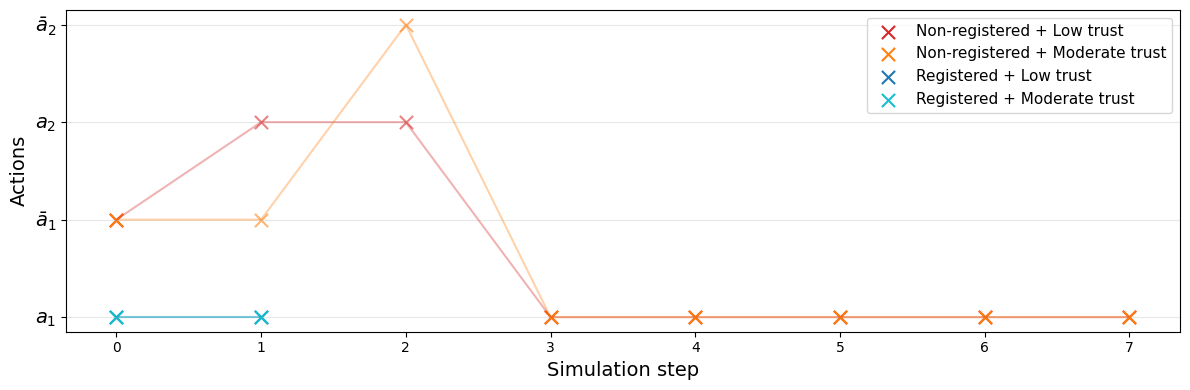

In [51]:
# OPTIMAL POLICY PLOTS
from learning.utils import plot_mean_optimal_strategy, plot_rewards_by_group

num_actions = int(max(df_steps_on["action_idx"].max(), df_steps_off["action_idx"].max())) + 1
apply_idx   = utils.Actions.APPLY_AND_GET_SHELTER.value  # si existeix al teu enum

plot_mean_optimal_strategy(
    exec_hist = exec_hist_on,
    initial_admin_state=initial_admin_on,
    initial_trust_type = initial_trust_on,
    num_actions= num_actions,
    engage_action_idx=apply_idx,
)


{'feature_names': ['intercept', 'prev_encounters', 'health_state', 'homelessness_duration', 'history_of_abuse', 'trust_building', 'age', 'income'], 'x_columns': ['prev_encounters', 'health_state', 'homelessness_duration', 'history_of_abuse', 'trust_building', 'age', 'income'], 'w_map': array([ 0.62425717,  0.33583153, -0.08769618, -0.39095764, -0.26143756,
        0.16077706, -0.05078435,  0.02666227]), 'cov_diag': [0.0037263849201603296, 0.011690036708172988, 0.005433929191914774, 0.007106351917304554, 0.005088648885595834, 0.01084109798534003, 0.005521609854493192, 0.004037600238121145], 'X_mean': array([5.61448427e+00, 2.25457206e+00, 5.13825896e+00, 2.52377469e-01,
       2.15874177e+00, 4.14813460e+01, 3.72923643e+02]), 'X_std': array([  4.75822418,   0.50809751,   3.56493418,   0.43437666,
         1.96728046,  11.55956155, 153.83528042])}

[PBRS] potentials at episode 0
peh_0 LOW_TRUST admin= non-registered phi= -0.726
peh_1 LOW_TRUST admin= non-registered phi= -1.138
peh_2 LOW_

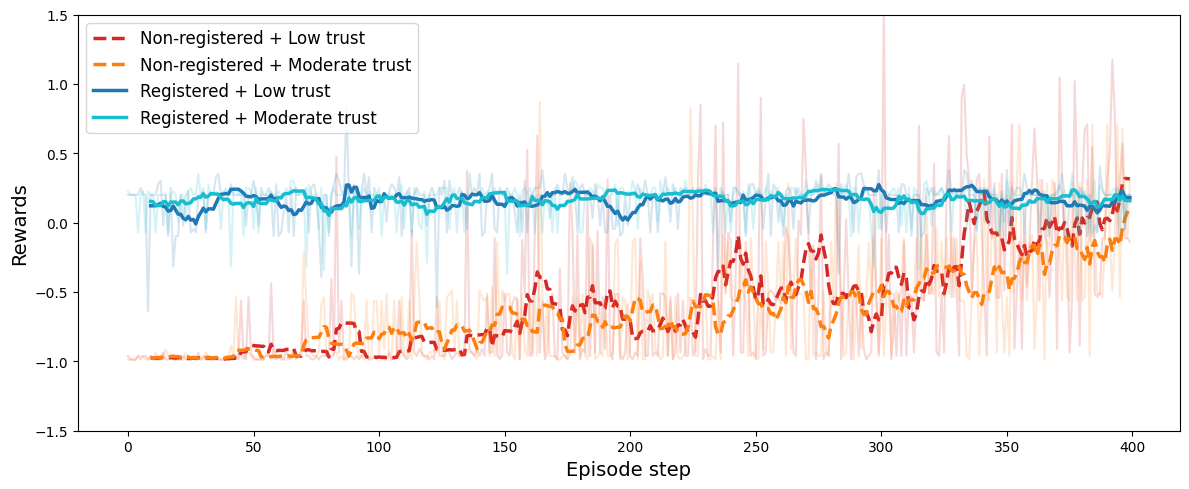


=== INIT CHECK (EVAL) ===
peh_0 admin=non-registered trust=LOW_TRUST loc=(np.int64(5), np.int64(6)) health=3.00 assigned_social_agents=1
peh_1 admin=non-registered trust=LOW_TRUST loc=(np.int64(3), np.int64(2)) health=3.00 assigned_social_agents=1
peh_2 admin=non-registered trust=LOW_TRUST loc=(np.int64(1), np.int64(2)) health=3.00 assigned_social_agents=1
peh_3 admin=non-registered trust=LOW_TRUST loc=(np.int64(0), np.int64(3)) health=3.00 assigned_social_agents=1
peh_4 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(1), np.int64(3)) health=3.00 assigned_social_agents=1
peh_5 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(2), np.int64(1)) health=3.00 assigned_social_agents=1
peh_6 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(3), np.int64(5)) health=3.00 assigned_social_agents=1
peh_7 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(6), np.int64(2)) health=3.00 assigned_social_agents=1
peh_8 admin=registered trust=LOW_TRUST loc=(np.int64(2), np.int64

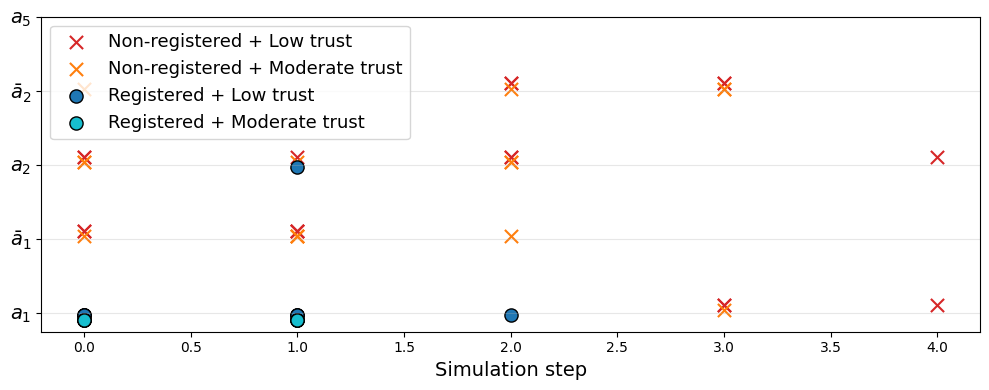

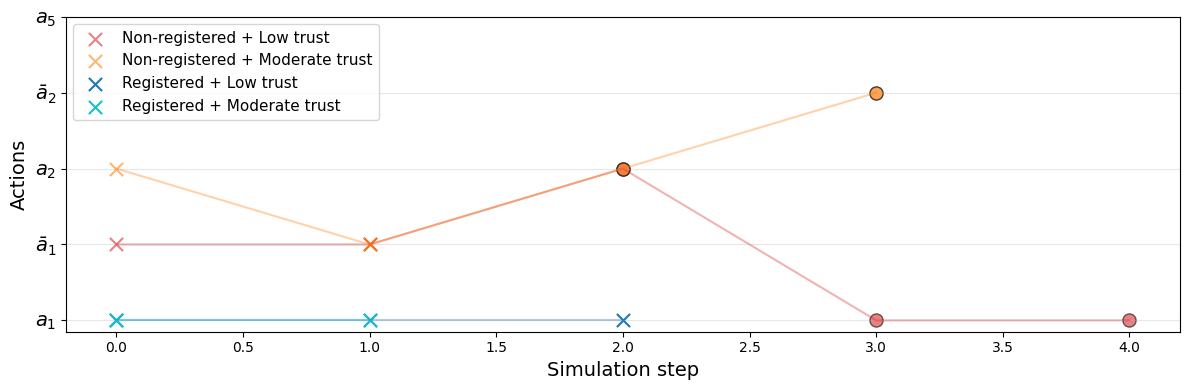

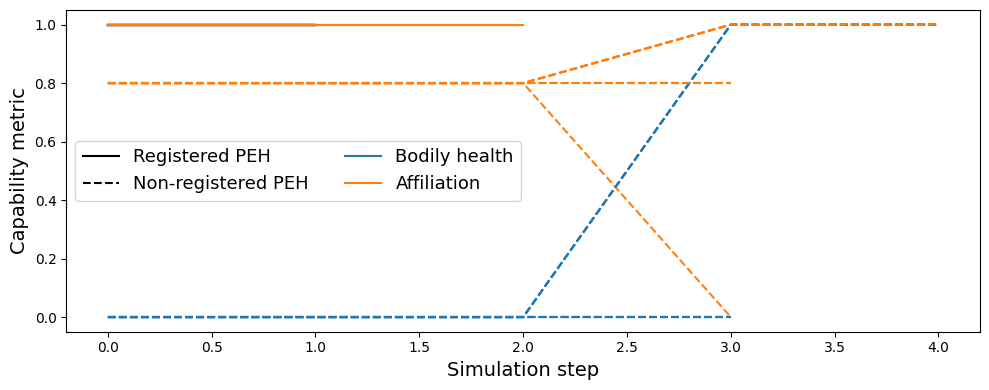

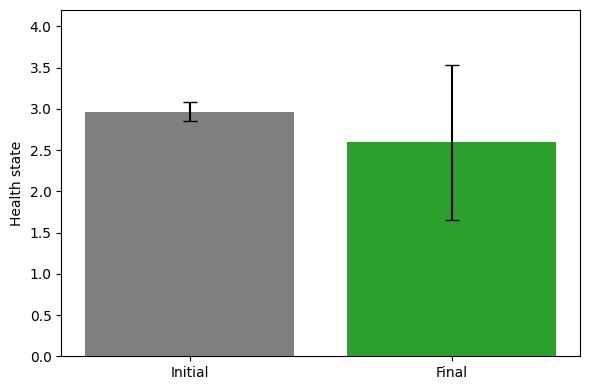

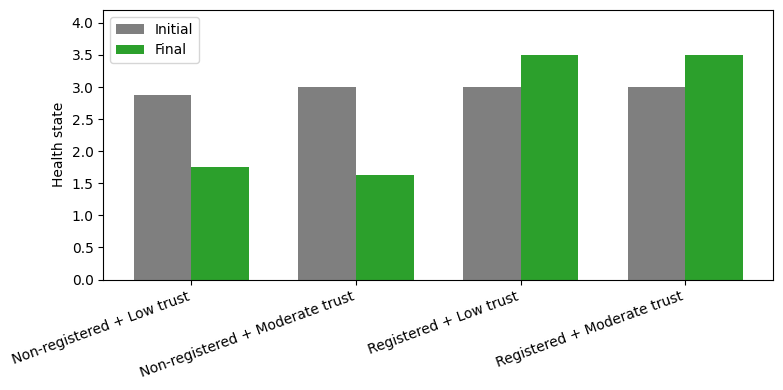

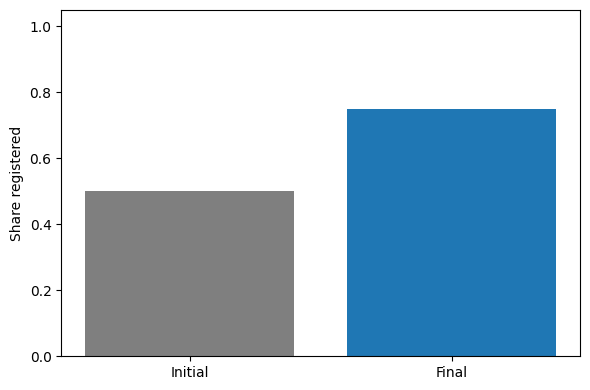

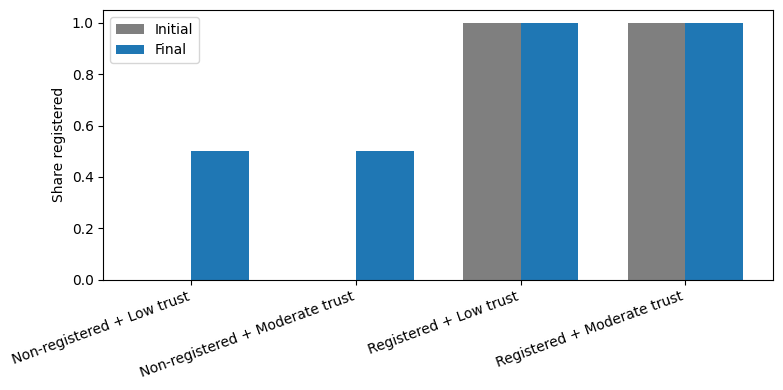

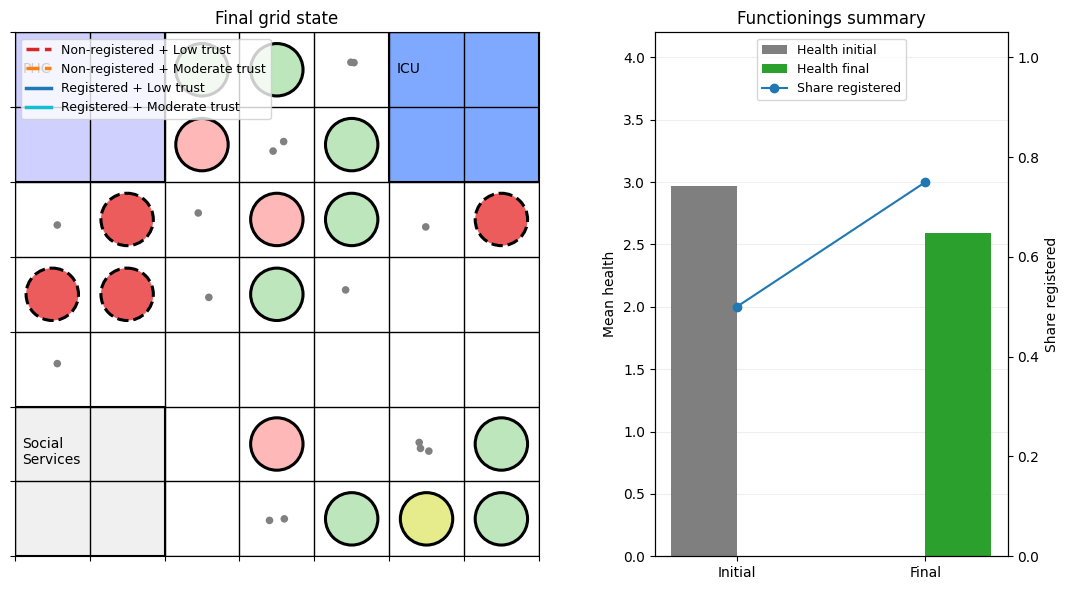

c:\Users\albaa\Escriptori\AABM\MDP\learning\qpbrs.py:756: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


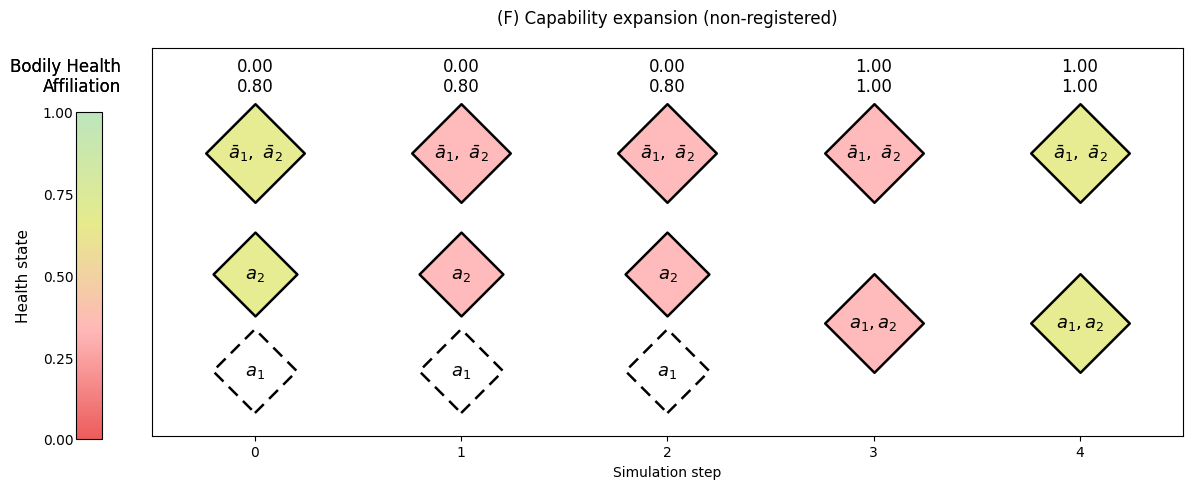

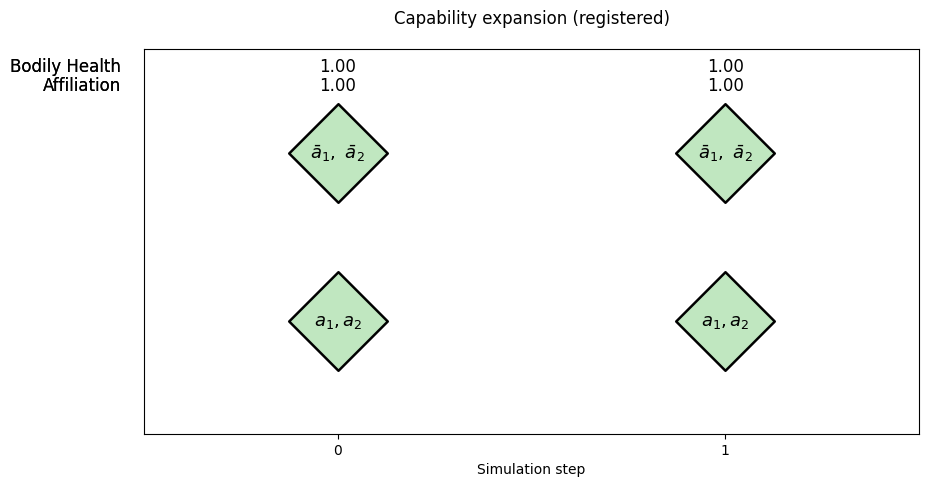

c:\Users\albaa\Escriptori\AABM\MDP\learning\qpbrs.py:870: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


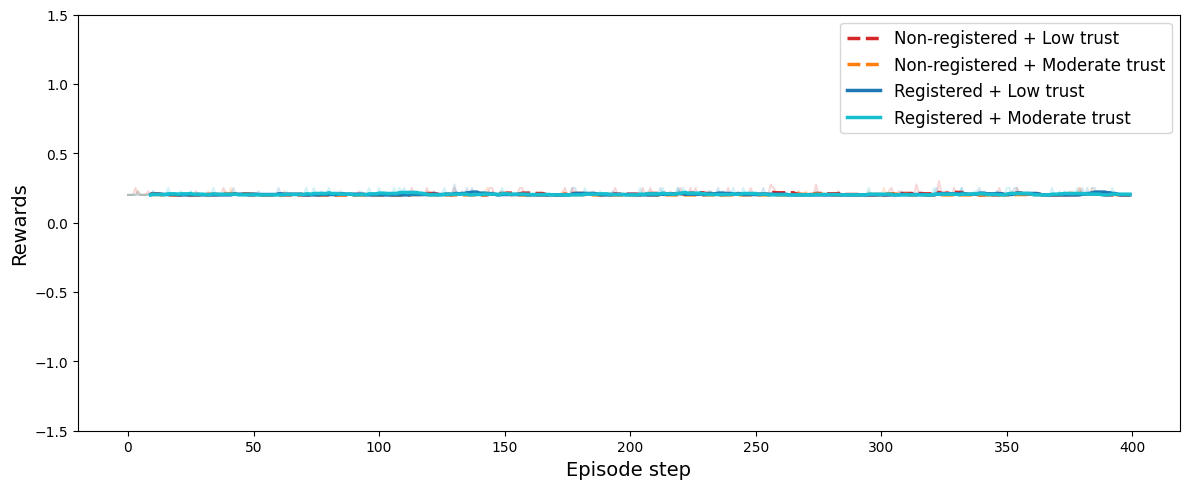


=== INIT CHECK (EVAL2) ===
peh_0 admin=non-registered trust=LOW_TRUST loc=(np.int64(2), np.int64(1)) health=3.00 assigned_social_agents=1
peh_1 admin=non-registered trust=LOW_TRUST loc=(np.int64(5), np.int64(4)) health=3.00 assigned_social_agents=1
peh_2 admin=non-registered trust=LOW_TRUST loc=(np.int64(3), np.int64(4)) health=3.00 assigned_social_agents=1
peh_3 admin=non-registered trust=LOW_TRUST loc=(np.int64(4), np.int64(6)) health=3.00 assigned_social_agents=1
peh_4 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(6), np.int64(3)) health=3.00 assigned_social_agents=1
peh_5 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(2), np.int64(3)) health=3.00 assigned_social_agents=1
peh_6 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(3), np.int64(2)) health=3.00 assigned_social_agents=0
peh_7 admin=non-registered trust=MODERATE_TRUST loc=(np.int64(6), np.int64(5)) health=3.00 assigned_social_agents=1
peh_8 admin=registered trust=LOW_TRUST loc=(np.int64(6), np.int6

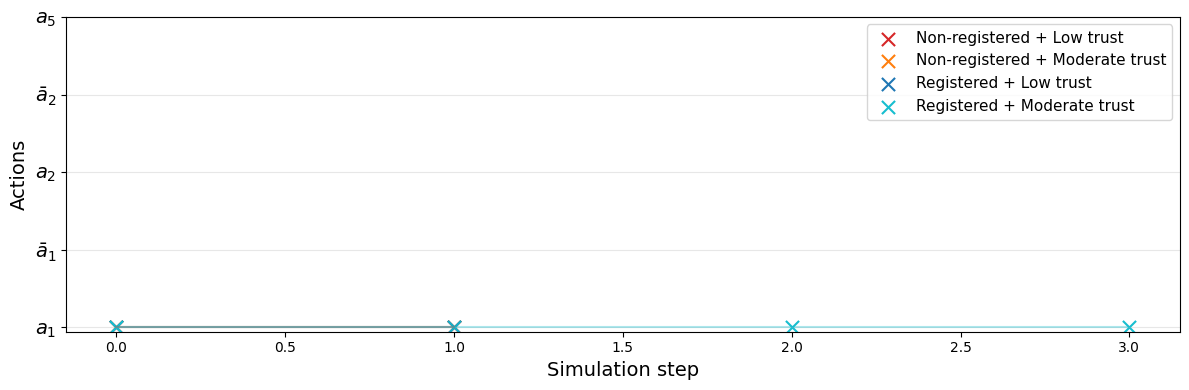

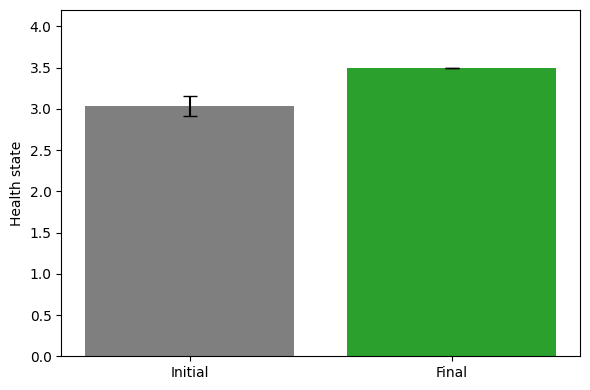

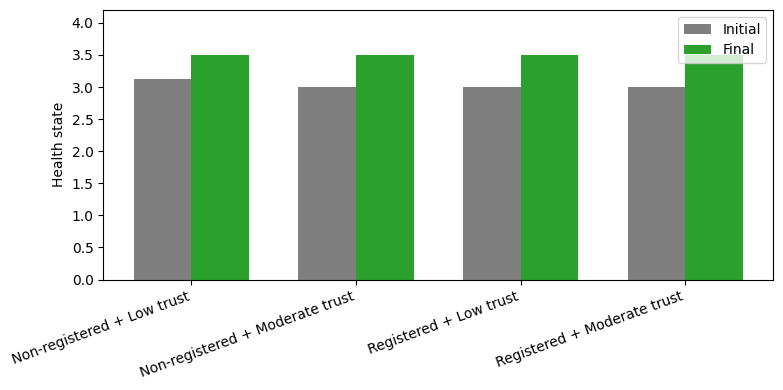

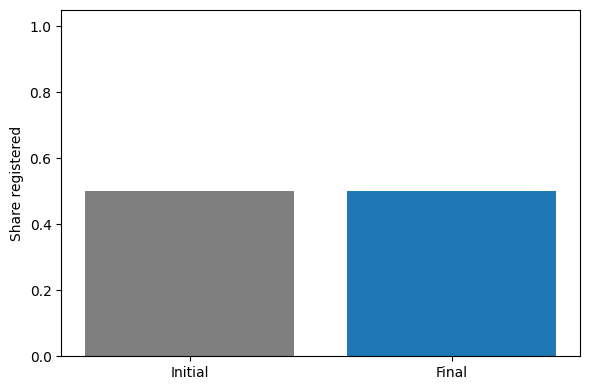

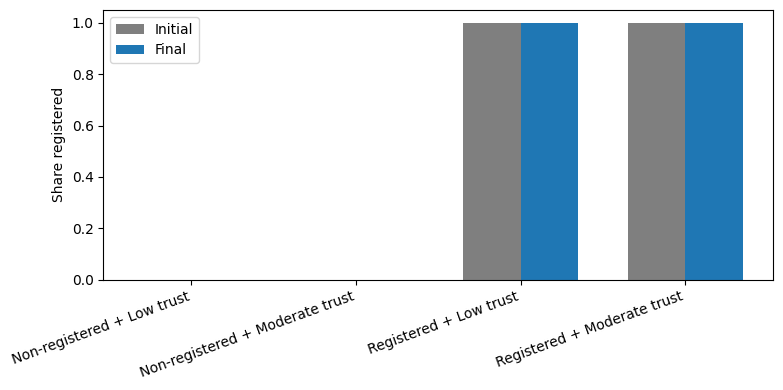

TypeError: final_state_summary_figure() missing 1 required positional argument: 'initial_trust_type'

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from learning.utils import (
    GROUP_COLORS,   
    GROUP_LS,
    GROUP_LABELS,
    health_to_color,
    group_key_from_initial)
from learning.qpbrs import capability_expansion_plot


def final_state_summary_env_caps_fun_costs(
    eval_env,
    df_steps,
    df_agents,
    meta,
    initial_admin_state,
    initial_trust_type,
    *,
    num_social_agents,
    # capability-expansion options
    agent_for_caps=None,              # e.g. "peh_0". If None -> picks first non-registered initially.
    conditional_indices=(0, 2),       # (a1, a2) indices in mask
    caps_title="Capabilities (capability expansion)",
    fun_title="Functionings (population)",
    # cost model
    cost_sw_per_timestep=50.0,
    cost_phc=30.0,
    cost_icu=1000.0,
    figsize=(13, 6),
):
    """
    Left: final environment grid with locations + agents (legend by group colors/linestyles)
    Right-top: capability expansion (from df_steps mask series for a chosen agent)
    Right-mid: aggregated functionings over time (mean health + share registered)
    Right-bottom: one-line economic costs text
    """

    # -------------------------
    # helpers
    # -------------------------
    def _parse_mask(m):
        # expects "1,1,1,0,1" or list-like
        if isinstance(m, (list, tuple, np.ndarray)):
            return np.array(m, dtype=int).tolist()
        s = str(m).strip()
        if s.startswith("[") and s.endswith("]"):
            s = s[1:-1]
        parts = [p.strip() for p in s.split(",") if p.strip() != ""]
        return [int(p) for p in parts]

    def _pick_agent_for_caps():
        # user’s preference: pick first initial non-registered if possible
        for ag, adm in initial_admin_state.items():
            if str(adm) == "non-registered":
                return ag
        # else first agent
        return list(initial_admin_state.keys())[0]

    def _get_locations():
        ctx = (meta.get("context") or meta.get("static_context") or {})
        return ctx.get("locations", {}) or {}

    def _coord_in_rect(x, y, rect_pos, rect_size):
        x0, y0 = rect_pos
        w, h = rect_size
        return (x0 <= x < x0 + w) and (y0 <= y < y0 + h)

    def _compute_costs():
        # timesteps from df_steps
        tmax = int(df_steps["t_global"].max())
        tmin = int(df_steps["t_global"].min())
        timesteps = tmax + 1 if tmin == 0 else tmax

        social_services_cost = cost_sw_per_timestep * float(num_social_agents) * float(timesteps)

        # healthcare: classify medical actions into PHC vs ICU using actor_x/actor_y vs location rectangles
        locs = _get_locations()
        phc_info = locs.get("PHC")
        icu_info = locs.get("ICU")

        med = df_steps[df_steps["action_name"].astype(str) == "RECEIVE_MEDICAL_ATTENTION"].copy()
        phc_visits = 0
        icu_adm = 0

        if not med.empty:
            if (phc_info and icu_info and ("actor_x" in med.columns) and ("actor_y" in med.columns)):
                phc_pos = tuple(phc_info["pos"])
                phc_size = tuple(phc_info.get("size", (1, 1)))
                icu_pos = tuple(icu_info["pos"])
                icu_size = tuple(icu_info.get("size", (1, 1)))

                for _, r in med.iterrows():
                    x = int(r["actor_x"]); y = int(r["actor_y"])
                    if _coord_in_rect(x, y, icu_pos, icu_size):
                        icu_adm += 1
                    elif _coord_in_rect(x, y, phc_pos, phc_size):
                        phc_visits += 1
                    else:
                        # fallback
                        phc_visits += 1
            else:
                phc_visits = int(len(med))

        healthcare_cost = cost_phc * phc_visits + cost_icu * icu_adm
        return social_services_cost, healthcare_cost, phc_visits, icu_adm

    # -------------------------
    # figure layout
    # -------------------------
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        1, 2,
        width_ratios=[2.2, 1.3],
        wspace=0.15
    )

    ax_grid = fig.add_subplot(gs[0, 0])

    # right column -> 3 rows: capabilities, functionings, costs text
    gs_right = gs[0, 1].subgridspec(3, 1, height_ratios=[1.25, 1.0, 0.18], hspace=0.25)
    ax_caps = fig.add_subplot(gs_right[0, 0])
    ax_fun  = fig.add_subplot(gs_right[1, 0])
    ax_cost = fig.add_subplot(gs_right[2, 0])

    # -------------------------
    # LEFT: environment grid + locations + agents + legend by group
    # -------------------------
    size = eval_env.size
    ax = ax_grid
    ax.set_xlim(0, size); ax.set_ylim(0, size)
    ax.set_aspect("equal"); ax.invert_yaxis()
    ax.set_xticks(np.arange(0, size+1)); ax.set_yticks(np.arange(0, size+1))
    ax.grid(True, color="black", linewidth=1)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_title("Final grid state")

    # locations
    ctx_locs = getattr(eval_env.context, "locations", {}) or {}
    # if env_stub has empty locations, use meta
    if not ctx_locs:
        ctx_locs = _get_locations()

    colour_map = {"PHC": "#d0d0ff", "ICU": "#7fa8ff", "SocialService": "#f0f0f0"}
    label_map  = {"PHC": "PHC", "ICU": "ICU", "SocialService": "Social\nServices"}

    for name, info in ctx_locs.items():
        base = np.array(info["pos"])
        w, h = info.get("size", (1, 1))
        col  = colour_map.get(name, "#dddddd")
        lab  = label_map.get(name, name[:3].upper())
        rect = plt.Rectangle(base, w, h, facecolor=col, edgecolor="black", linewidth=1.5)
        ax.add_patch(rect)
        ax.text(base[0]+0.1, base[1]+0.4, lab, fontsize=10, va="top", ha="left")

    # agents final positions
    for ag in eval_env.possible_agents:
        idx = eval_env.agent_name_mapping[ag]
        peh = eval_env.peh_agents[idx]
        x, y = peh.location

        grp = group_key_from_initial(initial_admin_state, initial_trust_type, ag)
        edge_col = GROUP_COLORS.get(grp, "black")
        ls = GROUP_LS.get(grp, "-")

        # keep fill by health (your existing mapping)
        face = health_to_color(peh.health_state, alpha=0.95)

        circ = plt.Circle(
            (x+0.5, y+0.5),
            radius=0.35,
            facecolor=face,
            edgecolor="edge_col",
            linewidth=2.2,
            linestyle=ls,
            zorder=3,
        )
        ax.add_patch(circ)

    # legend for groups (colors + linestyles)
    handles = []
    for g in ["NONREG_LOW", "NONREG_MOD", "REG_LOW", "REG_MOD"]:
        if g in GROUP_COLORS:
            handles.append(
                Line2D(
                    [0],[0],
                    color=GROUP_COLORS[g],
                    linestyle=GROUP_LS.get(g, "-"),
                    linewidth=2.5,
                    label=GROUP_LABELS.get(g, g),
                )
            )
    if handles:
        ax.legend(handles=handles, loc="upper right", fontsize=10, frameon=True)

    # -------------------------
    # RIGHT-TOP: capability expansion (from df_steps masks for chosen agent)
    # -------------------------
    if agent_for_caps is None:
        agent_for_caps = _pick_agent_for_caps()

    dfA = df_steps[df_steps["agent"] == agent_for_caps].sort_values("t_global").copy()

    if dfA.empty or ("mask" not in dfA.columns):
        ax_caps.text(0.5, 0.5, "No capability mask data", ha="center", va="center")
        ax_caps.set_axis_off()
    else:
        masks_over_time = [_parse_mask(m) for m in dfA["mask"].tolist()]

        # BH/AF series: if you have them in df_steps, use them; else leave blank arrays
        # (capability_expansion_plot can still work; it just won't print BH/AF numbers)
        bh_series = dfA["actor_bh"].tolist() if "actor_bh" in dfA.columns else []
        af_series = dfA["actor_af"].tolist() if "actor_af" in dfA.columns else []
        health_series = dfA["actor_health"].tolist() if "actor_health" in dfA.columns else []

        # Draw using your existing function
        capability_expansion_plot(
            masks_over_time,
            bh_series,
            af_series,
            health_series,
            conditional_indices=conditional_indices,
            title=caps_title + f" — {agent_for_caps}",
            ax=ax_caps,
            add_health_cbar=False,
        )

    # -------------------------
    # RIGHT-MID: functionings aggregated over time
    #   mean health + share registered over t_global
    # -------------------------
    panel = df_agents.sort_values("t_global").copy()

    # aggregate per timestep
    agg = panel.groupby("t_global").agg(
        mean_health=("health", "mean"),
        share_registered=("admin", lambda s: np.mean(s.astype(str) == "registered")),
    ).reset_index()

    ax_fun.set_title(fun_title)
    ax_fun.grid(axis="y", alpha=0.2)
    ax_fun.plot(agg["t_global"], agg["mean_health"] / 4.0, label="Mean health (scaled)")
    ax_fun.plot(agg["t_global"], agg["share_registered"], label="Share registered")

    ax_fun.set_xlabel("Simulation step")
    ax_fun.set_ylabel("Metric")
    ax_fun.set_ylim(0.0, 1.05)
    ax_fun.legend(fontsize=10, loc="upper left")

    # -------------------------
    # RIGHT-BOTTOM: costs line (text only)
    # -------------------------
    social_cost, health_cost, phc_visits, icu_adm = _compute_costs()

    ax_cost.axis("off")
    ax_cost.text(
        0.0, 0.5,
        f"Economic costs:  Social services = {social_cost:.0f} €   |   Healthcare = {health_cost:.0f} €   "
        f"(PHC={phc_visits}, ICU={icu_adm})",
        ha="left", va="center", fontsize=10, alpha=0.9
    )

    plt.tight_layout()
    plt.show()


C:\Users\albaa\AppData\Local\Temp\ipykernel_6180\959838711.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


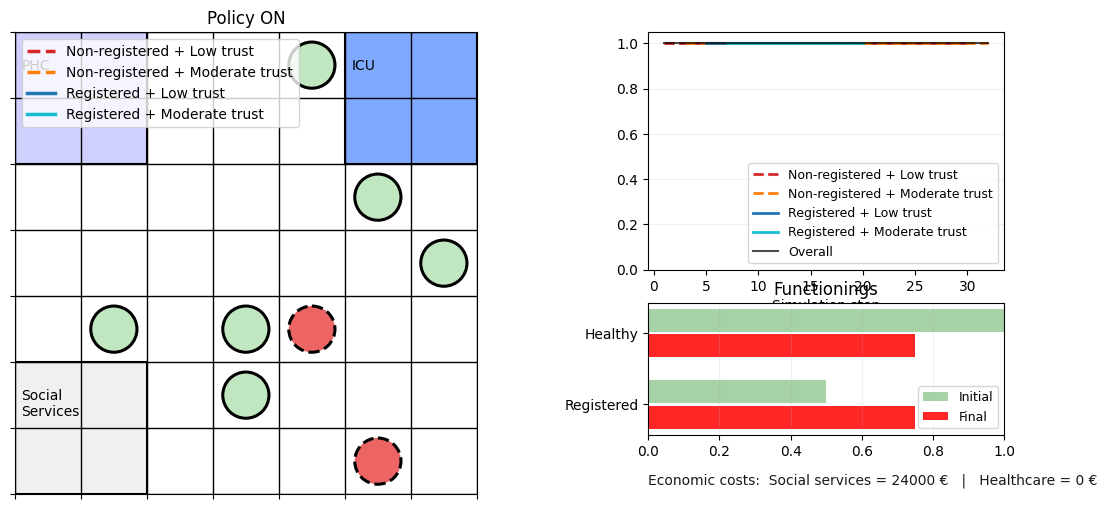

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_policy_summary_figure(
    eval_env,
    df_steps,
    df_agents,
    meta,
    initial_admin_state,
    initial_trust_type,
    *,
    # --- capability aggregation ---
    conditional_indices=(0, 2),  # (a1, a2) indices in mask
    # --- functionings ---
    healthy_threshold=3.0,       # define "healthy" as health >= this
    # --- costs ---
    num_social_agents=0,
    cost_sw_per_timestep=50.0,
    cost_phc=30.0,
    cost_icu=1000.0,
    # --- aesthetics ---
    figsize=(14, 6),
    title_left="Policy ON",
    title_caps="Capabilities",
    title_fun="Functionings",
):
    """
    Layout:
      LEFT  : grid + locations + agents + group legend
      RIGHT : [capabilities aggregated over time] (top)
              [functionings as small horizontal bars] (middle)
              [costs text line] (bottom)

    Requires (in your utils namespace):
      - GROUP_COLORS, GROUP_LABELS, GROUP_LS
      - group_key_from_initial(initial_admin_state, initial_trust_type, ag)
      - health_to_color(health, alpha=...)
    """

    # -------------------------
    # helpers
    # -------------------------
    def _parse_mask(m):
        # "1,1,0,1,1" -> [1,1,0,1,1]
        if isinstance(m, (list, tuple, np.ndarray)):
            return [int(x) for x in m]
        s = str(m).strip()
        if s.startswith("[") and s.endswith("]"):
            s = s[1:-1]
        parts = [p.strip() for p in s.split(",") if p.strip() != ""]
        return [int(p) for p in parts]

    def _get_locations():
        ctx = (meta.get("context") or meta.get("static_context") or {})
        return ctx.get("locations", {}) or {}

    def _coord_in_rect(x, y, pos, size):
        x0, y0 = pos
        w, h = size
        return (x0 <= x < x0 + w) and (y0 <= y < y0 + h)

    def _compute_costs():
        # timesteps
        tmin = int(df_steps["t_global"].min()) if "t_global" in df_steps.columns else 0
        tmax = int(df_steps["t_global"].max()) if "t_global" in df_steps.columns else 0
        timesteps = (tmax + 1) if tmin == 0 else max(1, tmax)

        social_cost = float(num_social_agents) * float(timesteps) * float(cost_sw_per_timestep)

        # healthcare costs from RECEIVE_MEDICAL_ATTENTION
        med = df_steps[df_steps["action_name"].astype(str) == "RECEIVE_MEDICAL_ATTENTION"].copy()
        phc_visits, icu_adm = 0, 0

        locs = _get_locations()
        phc = locs.get("PHC")
        icu = locs.get("ICU")

        if not med.empty:
            if phc and icu and ("actor_x" in med.columns) and ("actor_y" in med.columns):
                phc_pos = tuple(phc["pos"]); phc_size = tuple(phc.get("size", (1, 1)))
                icu_pos = tuple(icu["pos"]); icu_size = tuple(icu.get("size", (1, 1)))

                for _, r in med.iterrows():
                    x = int(r["actor_x"]); y = int(r["actor_y"])
                    if _coord_in_rect(x, y, icu_pos, icu_size):
                        icu_adm += 1
                    elif _coord_in_rect(x, y, phc_pos, phc_size):
                        phc_visits += 1
                    else:
                        # fallback: assume PHC
                        phc_visits += 1
            else:
                phc_visits = int(len(med))

        health_cost = cost_phc * phc_visits + cost_icu * icu_adm
        return social_cost, health_cost, phc_visits, icu_adm

    # -------------------------
    # figure & layout
    # -------------------------
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[2.2, 1.2], wspace=0.15)

    ax_grid = fig.add_subplot(gs[0, 0])
    gs_r = gs[0, 1].subgridspec(3, 1, height_ratios=[1.35, 0.75, 0.15], hspace=0.25)
    ax_caps = fig.add_subplot(gs_r[0, 0])
    ax_fun  = fig.add_subplot(gs_r[1, 0])
    ax_cost = fig.add_subplot(gs_r[2, 0])

    # -------------------------
    # LEFT: environment grid
    # -------------------------
    size = getattr(eval_env, "size", None) or int(meta.get("grid_size", 8))
    ax = ax_grid
    ax.set_xlim(0, size); ax.set_ylim(0, size)
    ax.set_aspect("equal"); ax.invert_yaxis()
    ax.set_xticks(np.arange(0, size+1)); ax.set_yticks(np.arange(0, size+1))
    ax.grid(True, color="black", linewidth=1)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_title(title_left)

    # locations (prefer env.context.locations, else meta)
    ctx_locs = getattr(getattr(eval_env, "context", None), "locations", {}) or {}
    if not ctx_locs:
        ctx_locs = _get_locations()

    colour_map = {"PHC": "#d0d0ff", "ICU": "#7fa8ff", "SocialService": "#f0f0f0"}
    label_map  = {"PHC": "PHC", "ICU": "ICU", "SocialService": "Social\nServices"}

    for name, info in (ctx_locs or {}).items():
        base = np.array(info["pos"])
        w, h = info.get("size", (1, 1))
        rect = plt.Rectangle(base, w, h,
                             facecolor=colour_map.get(name, "#dddddd"),
                             edgecolor="black", linewidth=1.5)
        ax.add_patch(rect)
        ax.text(base[0] + 0.1, base[1] + 0.4,
                label_map.get(name, name),
                fontsize=10, va="top", ha="left")

    # agents (final)
    for ag in eval_env.possible_agents:
        idx = eval_env.agent_name_mapping[ag]
        peh = eval_env.peh_agents[idx]
        x, y = peh.location

        grp = group_key_from_initial(initial_admin_state, initial_trust_type, ag)
        edge_col = GROUP_COLORS.get(grp, "black")
        ls = GROUP_LS.get(grp, "-")
        face = health_to_color(peh.health_state, alpha=0.95)

        circ = plt.Circle((x+0.5, y+0.5), radius=0.35,
                          facecolor=face,
                          edgecolor="black",
                          linewidth=2.2,
                          linestyle=ls,
                          zorder=3)
        ax.add_patch(circ)

    # group legend (colors + linestyles)
    handles = []
    for g in ["NONREG_LOW", "NONREG_MOD", "REG_LOW", "REG_MOD"]:
        if g in GROUP_COLORS:
            handles.append(Line2D([0],[0],
                                  color=GROUP_COLORS[g],
                                  linestyle=GROUP_LS.get(g, "-"),
                                  linewidth=2.5,
                                  label=GROUP_LABELS.get(g, g)))
    if handles:
        ax.legend(handles=handles, loc="upper left", fontsize=10, frameon=True)

    # -------------------------
    # RIGHT-TOP: aggregated capabilities
    # We compute, for each t_global and group:
    #   restored_share = mean( mask[a1]==1 and mask[a2]==1 )
    # -------------------------
    a1, a2 = conditional_indices

    dfc = df_steps.copy()
    if "mask" not in dfc.columns:
        ax_caps.text(0.5, 0.5, "No mask column in df_steps", ha="center", va="center")
        ax_caps.set_axis_off()
    else:
        dfc = dfc.sort_values("t_global")
        # parse masks -> two boolean columns
        parsed = dfc["mask"].map(_parse_mask)
        dfc["_a1"] = parsed.map(lambda m: int(m[a1]) if len(m) > a1 else 0)
        dfc["_a2"] = parsed.map(lambda m: int(m[a2]) if len(m) > a2 else 0)
        dfc["_restored"] = ((dfc["_a1"] == 1) & (dfc["_a2"] == 1)).astype(int)

        # group is already present in df_steps ("group")
        if "group" not in dfc.columns:
            # fallback compute group from initial dicts
            dfc["group"] = dfc["agent"].map(lambda ag: group_key_from_initial(initial_admin_state, initial_trust_type, ag))

        agg_g = dfc.groupby(["t_global", "group"])["_restored"].mean().reset_index()
        agg_all = dfc.groupby("t_global")["_restored"].mean().reset_index()

        #ax_caps.set_title(title_caps + f" — restored(a{a1+1}&a{a2+1})")
        ax_caps.set_ylim(0.0, 1.05)
        #ax_caps.set_ylabel("Share restored")
        ax_caps.grid(axis="y", alpha=0.2)

        # per group lines (colors)
        for g in ["NONREG_LOW", "NONREG_MOD", "REG_LOW", "REG_MOD"]:
            gdf = agg_g[agg_g["group"] == g]
            if gdf.empty:
                continue
            ax_caps.plot(gdf["t_global"], gdf["_restored"],
                         color=GROUP_COLORS.get(g, None),
                         linestyle=GROUP_LS.get(g, "-"),
                         linewidth=2.0,
                         label=GROUP_LABELS.get(g, g))

        # overall line (thin, black)
        ax_caps.plot(agg_all["t_global"], agg_all["_restored"],
                     color="black", linewidth=1.5, alpha=0.7, label="Overall")

        ax_caps.legend(fontsize=9, loc="lower right")
        ax_caps.set_xlabel("Simulation step")

    # -------------------------
    # RIGHT-MID: functionings as small horizontal bars
    #   Healthy% (health >= threshold)  Initial vs Final
    #   Registered%                    Initial vs Final
    # -------------------------
    dfa = df_agents.copy()
    if "t_global" not in dfa.columns:
        # fallback: treat whole df as final-only
        t0 = 0
        tT = 0
        init_panel = dfa
        final_panel = dfa
    else:
        t0 = int(dfa["t_global"].min())
        tT = int(dfa["t_global"].max())
        init_panel  = dfa[dfa["t_global"] == t0]
        final_panel = dfa[dfa["t_global"] == tT]

    init_healthy = float(np.mean(init_panel["health"].astype(float) >= healthy_threshold)) if not init_panel.empty else 0.0
    final_healthy = float(np.mean(final_panel["health"].astype(float) >= healthy_threshold)) if not final_panel.empty else 0.0

    init_reg = float(np.mean(init_panel["admin"].astype(str) == "registered")) if not init_panel.empty else 0.0
    final_reg = float(np.mean(final_panel["admin"].astype(str) == "registered")) if not final_panel.empty else 0.0

    ax_fun.set_title(title_fun)
    ax_fun.set_xlim(0.0, 1.0)
    #ax_fun.set_xlabel("Share")

    # two rows, each with initial and final bars
    y = np.array([1, 0])  # Healthy on top, Registered below
    labels = [f"Healthy", "Registered"]
    # bar heights / offsets
    h = 0.32
    ax_fun.barh(y + 0.18, [init_healthy, init_reg], height=h, alpha=0.35, label="Initial", color= "green")
    ax_fun.barh(y - 0.18, [final_healthy, final_reg], height=h, alpha=0.85, label="Final", color = "red")
    ax_fun.set_yticks(y)
    ax_fun.set_yticklabels(labels)
    ax_fun.grid(axis="x", alpha=0.2)
    ax_fun.legend(fontsize=9, loc="lower right")

    # -------------------------
    # RIGHT-BOTTOM: costs line (text only) — under functionings
    # -------------------------
    social_cost, health_cost, phc_visits, icu_adm = _compute_costs()
    ax_cost.axis("off")
    ax_cost.text(
        0.0, 0.5,
        f"Economic costs:  Social services = {social_cost:.0f} €   |   Healthcare = {health_cost:.0f} €",
        ha="left", va="center", fontsize=10, alpha=0.9
    )

    plt.tight_layout()
    plt.show()

plot_policy_summary_figure(
    env_on,
    df_steps_on,
    df_agents_on,
    meta_on,
    initial_admin_on,
    initial_trust_on,
    num_social_agents=15,     # IMPORTANT pels costos socials
    conditional_indices=(0, 2),   # els teus a1/a2
    healthy_threshold=3.0,
)


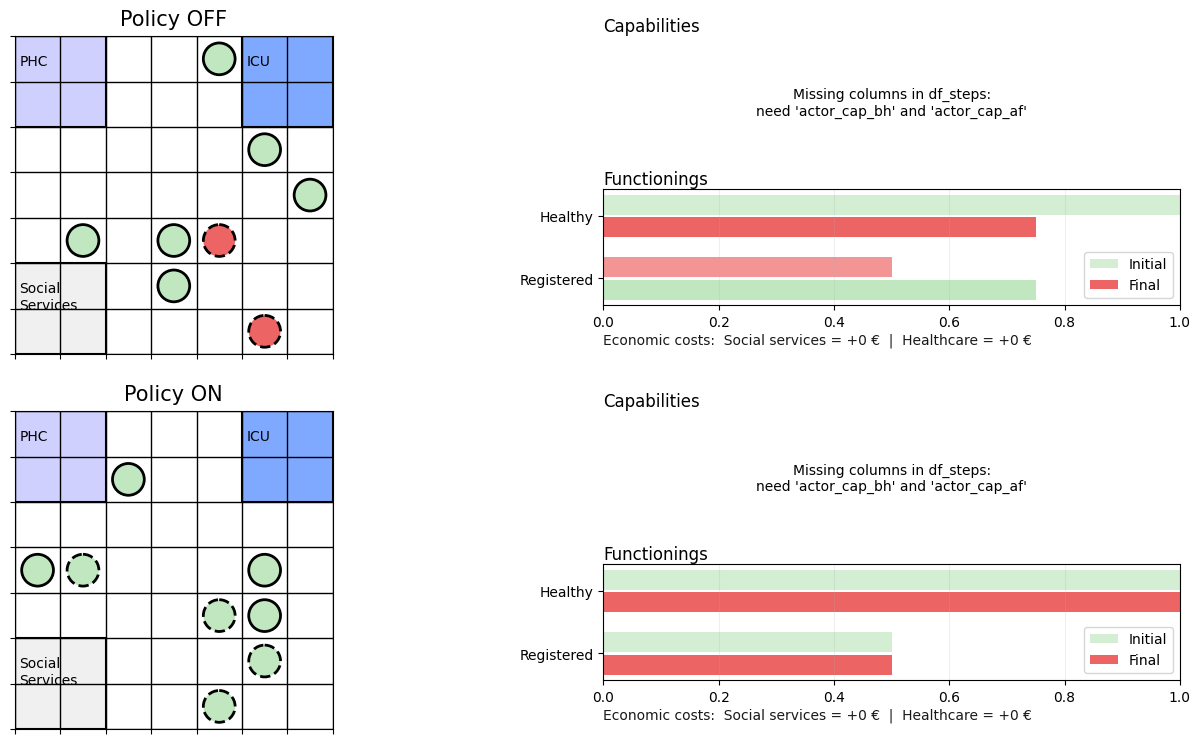

In [87]:

def plot_policy_comparison_summary(
    env_on, df_steps_on, df_agents_on, meta_on, initial_admin_on, initial_trust_on,
    env_off, df_steps_off, df_agents_off, meta_off, initial_admin_off, initial_trust_off,
    *,
    # columnes de capabilities a df_steps
    bh_col="actor_cap_bh",
    af_col="actor_cap_af",
    # functionings
    healthy_threshold=3.0,
    # estètica
    figsize=(18, 9),
    grid_width_ratio=1.35,
    right_width_ratio=1.0,
    wspace=0.06,
    hspace=0.18,
    title_on="Policy OFF",
    title_off="Policy ON",
    font_big=15,
    font_med=12,
    font_small=10,
    # social workers
    show_social_workers=True,
):
    """
    Figura 2x2:
      fila 1: ON  -> [Grid | (Capabilities, Functionings, Costs)]
      fila 2: OFF -> [Grid | (Capabilities, Functionings, Costs)]

    - Grid: cercles color = salut final (health_to_color), linestyle '--' si non-registered
    - Capabilities: BH/AF agregat per grup (4 bars per mètrica) amb colors vermell-verd
    - Functionings: Healthy% i Registered% (initial vs final) amb verd per la barra més alta
    - Costs: línia de text (delta pressupost: final - inicial) => negatiu si hi ha despesa
    """

    # -------- helpers --------
    def _get_locations(env, meta):
        ctx_locs = getattr(getattr(env, "context", None), "locations", {}) or {}
        if ctx_locs:
            return ctx_locs
        ctx = (meta.get("context") or meta.get("static_context") or {})
        return ctx.get("locations", {}) or {}

    def _lerp(c1, c2, t):
        # c1,c2 RGBA; t in [0,1]
        t = float(np.clip(t, 0.0, 1.0))
        return tuple((1 - t) * np.array(c1) + t * np.array(c2))

    def _cap_colors(values, c_bad, c_good):
        # gradient vermell->verd dins cada mètrica
        v = np.array(values, dtype=float)
        mask = np.isfinite(v)
        if not np.any(mask):
            return [c_bad] * len(values)
        vmin = float(np.nanmin(v[mask]))
        vmax = float(np.nanmax(v[mask]))
        if np.isclose(vmin, vmax):
            return [c_good] * len(values)
        cols = []
        for x in v:
            if not np.isfinite(x):
                cols.append((0.7, 0.7, 0.7, 0.6))
            else:
                t = (x - vmin) / (vmax - vmin)
                cols.append(_lerp(c_bad, c_good, t))
        return cols

    def _functioning_pair_colors(a, b, c_bad, c_good):
        # retorna colors (a_col, b_col) amb verd a la barra més alta
        if a >= b:
            return c_good, c_bad
        else:
            return c_bad, c_good

    def _budgets_delta_text(env, meta):
        # costs = final - initial (negatiu si s’ha gastat)
        ctx = getattr(env, "context", None)
        if ctx is None:
            return "Economic costs:  Social services = n/a  |  Healthcare = n/a"

        init_h = None
        init_s = None
        try:
            # prefer meta si hi és
            if "initial_budgets" in meta:
                init_h = float(meta["initial_budgets"].get("healthcare_budget"))
                init_s = float(meta["initial_budgets"].get("social_service_budget"))
        except Exception:
            pass

        # fallback: del primer snapshot de df_agents si existeix
        if init_h is None or init_s is None:
            try:
                if "t_global" in df_agents_on.columns:
                    t0 = int(df_agents_on["t_global"].min())
                    row0 = df_agents_on[df_agents_on["t_global"] == t0].iloc[0]
                    init_h = float(row0.get("healthcare_budget", np.nan))
                    init_s = float(row0.get("social_service_budget", np.nan))
            except Exception:
                pass

        # últim recurs: pressupost actual com a “init” (no ideal, però evita crash)
        if init_h is None or not np.isfinite(init_h):
            init_h = float(getattr(ctx, "healthcare_budget", 0.0))
        if init_s is None or not np.isfinite(init_s):
            init_s = float(getattr(ctx, "social_service_budget", 0.0))

        fin_h = float(getattr(ctx, "healthcare_budget", init_h))
        fin_s = float(getattr(ctx, "social_service_budget", init_s))

        delta_s = fin_s - init_s
        delta_h = fin_h - init_h
        return f"Economic costs:  Social services = {delta_s:+.0f} €  |  Healthcare = {delta_h:+.0f} €"

    def _draw_grid(ax, env, meta, initial_admin_state, initial_trust_type, title):
        size = getattr(env, "size", int(meta.get("grid_size", 8)))
        ctx_locs = _get_locations(env, meta)

        ax.set_xlim(0, size); ax.set_ylim(0, size)
        ax.set_aspect("equal"); ax.invert_yaxis()
        ax.set_xticks(np.arange(0, size+1)); ax.set_yticks(np.arange(0, size+1))
        ax.grid(True, color="black", linewidth=1)
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.set_title(title, fontsize=font_big, pad=8)

        colour_map = {"PHC": "#d0d0ff", "ICU": "#7fa8ff", "SocialService": "#f0f0f0"}
        label_map  = {"PHC": "PHC", "ICU": "ICU", "SocialService": "Social\nServices"}

        for name, info in (ctx_locs or {}).items():
            base = np.array(info["pos"])
            w, h = info.get("size", (1, 1))
            rect = plt.Rectangle(base, w, h,
                                 facecolor=colour_map.get(name, "#dddddd"),
                                 edgecolor="black", linewidth=1.5)
            ax.add_patch(rect)
            ax.text(base[0]+0.1, base[1]+0.4, label_map.get(name, name),
                    fontsize=font_small, va="top", ha="left")

        # social workers (final positions)
        if show_social_workers and hasattr(env, "socserv_agents") and env.socserv_agents:
            n_sw = len(env.socserv_agents)
            for k, sw in enumerate(env.socserv_agents):
                x, y = sw.location
                jitter = 0.10
                ang = 2 * np.pi * (k / max(1, n_sw))
                dx = jitter * np.cos(ang)
                dy = jitter * np.sin(ang)
                ax.scatter(x+0.5+dx, y+0.5+dy, s=30, color="grey", edgecolors="none", zorder=2)

        # PEH final
        for ag in env.possible_agents:
            idx = env.agent_name_mapping[ag]
            peh = env.peh_agents[idx]
            x, y = peh.location
            face = health_to_color(peh.health_state, alpha=0.95)

            # només linestyle per admin final (sense llegenda)
            is_reg = (peh.administrative_state == "registered")
            ls = "-" if is_reg else "--"

            circ = plt.Circle((x+0.5, y+0.5), radius=0.35,
                              facecolor=face, edgecolor="black",
                              linewidth=2.0, linestyle=ls, zorder=3)
            ax.add_patch(circ)

    def _draw_right(ax_caps, ax_fun, ax_cost, df_steps, df_agents, meta, env,
                    initial_admin_state, initial_trust_type):

        # colors “extrems” de salut
        c_bad = health_to_color(1.0, alpha=0.95)   # vermell-ish
        c_good = health_to_color(4.0, alpha=0.95)  # verd-ish

        # ----- Capabilities (BH/AF per grup) -----
        ax_caps.set_title("Capabilities", loc="left", fontsize=font_med, pad=4)
        ax_caps.grid(axis="x", alpha=0.2)
        ax_caps.set_xlim(0.0, 1.0)
        ax_caps.tick_params(labelsize=font_small)

        if (bh_col not in df_steps.columns) or (af_col not in df_steps.columns):
            ax_caps.text(0.5, 0.5, f"Missing columns in df_steps:\nneed '{bh_col}' and '{af_col}'",
                         ha="center", va="center", fontsize=font_small)
            ax_caps.set_axis_off()
        else:
            dfc = df_steps.copy()
            if "group" not in dfc.columns:
                dfc["group"] = dfc["agent"].map(
                    lambda ag: group_key_from_initial(initial_admin_state, initial_trust_type, ag)
                )

            groups = ["NONREG_LOW", "NONREG_MOD", "REG_LOW", "REG_MOD"]
            cap = dfc.groupby("group")[[bh_col, af_col]].mean()

            bh_vals = [float(cap.loc[g, bh_col]) if g in cap.index else np.nan for g in groups]
            af_vals = [float(cap.loc[g, af_col]) if g in cap.index else np.nan for g in groups]

            # colors amb gradient vermell->verd per cada mètrica
            bh_cols = _cap_colors(bh_vals, c_bad, c_good)
            af_cols = _cap_colors(af_vals, c_bad, c_good)

            # BH row i AF row, amb offset per grup
            y_bh, y_af = 1.0, 0.0
            bar_h = 0.16
            offsets = np.array([+0.24, +0.08, -0.08, -0.24])

            for i, g in enumerate(groups):
                if np.isfinite(bh_vals[i]):
                    ax_caps.barh(y_bh + offsets[i], bh_vals[i], height=bar_h, color=bh_cols[i])
                if np.isfinite(af_vals[i]):
                    ax_caps.barh(y_af + offsets[i], af_vals[i], height=bar_h, color=af_cols[i])

            ax_caps.set_yticks([y_bh, y_af])
            ax_caps.set_yticklabels(["Bodily health", "Affiliation"], fontsize=font_small)

        # ----- Functionings (Healthy / Registered; Initial vs Final) -----
        ax_fun.set_title("Functionings", loc="left", fontsize=font_med, pad=4)
        ax_fun.set_xlim(0.0, 1.0)
        ax_fun.grid(axis="x", alpha=0.2)
        ax_fun.tick_params(labelsize=font_small)

        dfa = df_agents.copy()
        if "t_global" in dfa.columns and len(dfa) > 0:
            t0 = int(dfa["t_global"].min())
            tT = int(dfa["t_global"].max())
            init_panel  = dfa[dfa["t_global"] == t0]
            final_panel = dfa[dfa["t_global"] == tT]
        else:
            init_panel = dfa
            final_panel = dfa

        init_healthy = float(np.mean(init_panel["health"].astype(float) >= healthy_threshold)) if not init_panel.empty else 0.0
        final_healthy = float(np.mean(final_panel["health"].astype(float) >= healthy_threshold)) if not final_panel.empty else 0.0
        init_reg = float(np.mean(init_panel["admin"].astype(str) == "registered")) if not init_panel.empty else 0.0
        final_reg = float(np.mean(final_panel["admin"].astype(str) == "registered")) if not final_panel.empty else 0.0

        # colors: verd per la barra més alta, vermell per la més baixa (per cada mètrica)
        h_init_col, h_final_col = _functioning_pair_colors(init_healthy, final_healthy, c_bad, c_good)
        r_init_col, r_final_col = _functioning_pair_colors(init_reg, final_reg, c_bad, c_good)

        y = np.array([1, 0], dtype=float)
        h = 0.32

        ax_fun.barh(y[0] + 0.18, init_healthy, height=h, color=h_init_col, alpha=0.65, label="Initial")
        ax_fun.barh(y[0] - 0.18, final_healthy, height=h, color=h_final_col, alpha=0.95, label="Final")

        ax_fun.barh(y[1] + 0.18, init_reg, height=h, color=r_init_col, alpha=0.65)
        ax_fun.barh(y[1] - 0.18, final_reg, height=h, color=r_final_col, alpha=0.95)

        ax_fun.set_yticks(y)
        ax_fun.set_yticklabels(["Healthy", "Registered"], fontsize=font_small)
        ax_fun.legend(fontsize=font_small, loc="lower right")

        # ----- Costs (text) -----
        ax_cost.axis("off")
        ax_cost.text(
            0.0, 0.5,
            _budgets_delta_text(env, meta),
            ha="left", va="center", fontsize=font_small, alpha=0.9,
            transform=ax_cost.transAxes
        )

    # --------- layout (2 rows x 2 cols) ----------
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(
        2, 2,
        width_ratios=[grid_width_ratio, right_width_ratio],
        wspace=wspace,
        hspace=hspace
    )

    # row 0 (ON)
    ax_grid_on = fig.add_subplot(gs[0, 0])
    gs_r_on = gs[0, 1].subgridspec(3, 1, height_ratios=[1.15, 1.00, 0.25], hspace=0.22)
    ax_caps_on = fig.add_subplot(gs_r_on[0, 0])
    ax_fun_on  = fig.add_subplot(gs_r_on[1, 0])
    ax_cost_on = fig.add_subplot(gs_r_on[2, 0])

    # row 1 (OFF)
    ax_grid_off = fig.add_subplot(gs[1, 0])
    gs_r_off = gs[1, 1].subgridspec(3, 1, height_ratios=[1.15, 1.00, 0.25], hspace=0.22)
    ax_caps_off = fig.add_subplot(gs_r_off[0, 0])
    ax_fun_off  = fig.add_subplot(gs_r_off[1, 0])
    ax_cost_off = fig.add_subplot(gs_r_off[2, 0])

    # --------- draw all ----------
    _draw_grid(ax_grid_on, env_on, meta_on, initial_admin_on, initial_trust_on, title_on)
    _draw_right(ax_caps_on, ax_fun_on, ax_cost_on,
                df_steps_on, df_agents_on, meta_on, env_on,
                initial_admin_on, initial_trust_on)

    _draw_grid(ax_grid_off, env_off, meta_off, initial_admin_off, initial_trust_off, title_off)
    _draw_right(ax_caps_off, ax_fun_off, ax_cost_off,
                df_steps_off, df_agents_off, meta_off, env_off,
                initial_admin_off, initial_trust_off)

    plt.show()

plot_policy_comparison_summary(
    env_on, df_steps_on, df_agents_on, meta_on, initial_admin_on, initial_trust_on,
    env_off, df_steps_off, df_agents_off, meta_off, initial_admin_off, initial_trust_off,
    bh_col="actor_cap_bh",   # o "actor_cap_bh" segons com ho guardis
    af_col="actor_cap_af",
    figsize=(18, 9),
)


In [82]:
df_agents_on.columns

Index(['run_id', 'scenario', 'policy_tag', 't_global', 'healthcare_budget',
       'social_service_budget', 'agent', 'group', 'x', 'y', 'health', 'admin',
       'trust', 'engagement_counter', 'non_engagement_counter'],
      dtype='object')

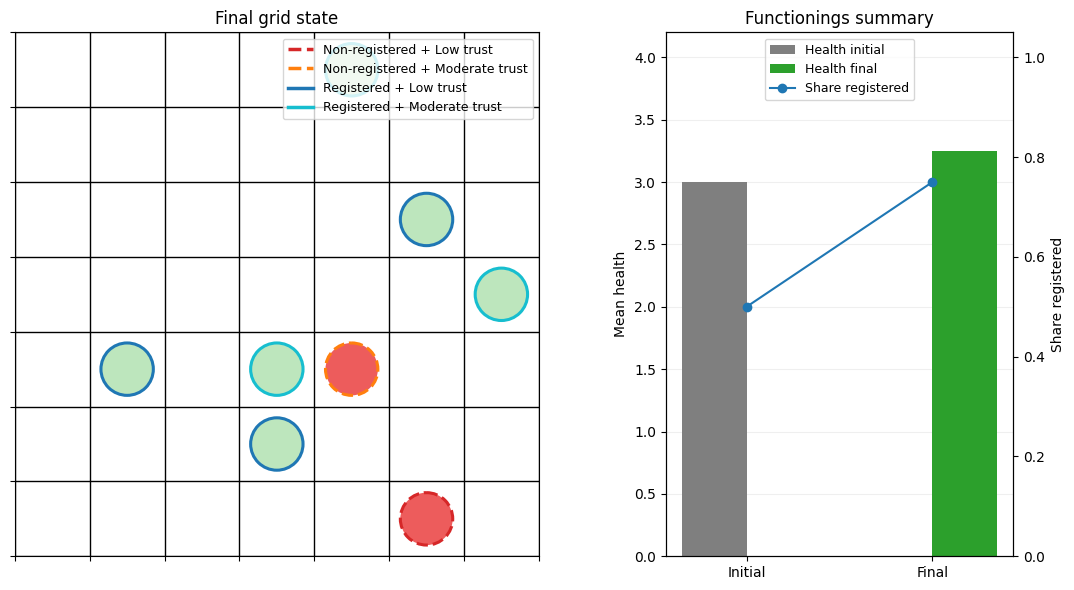

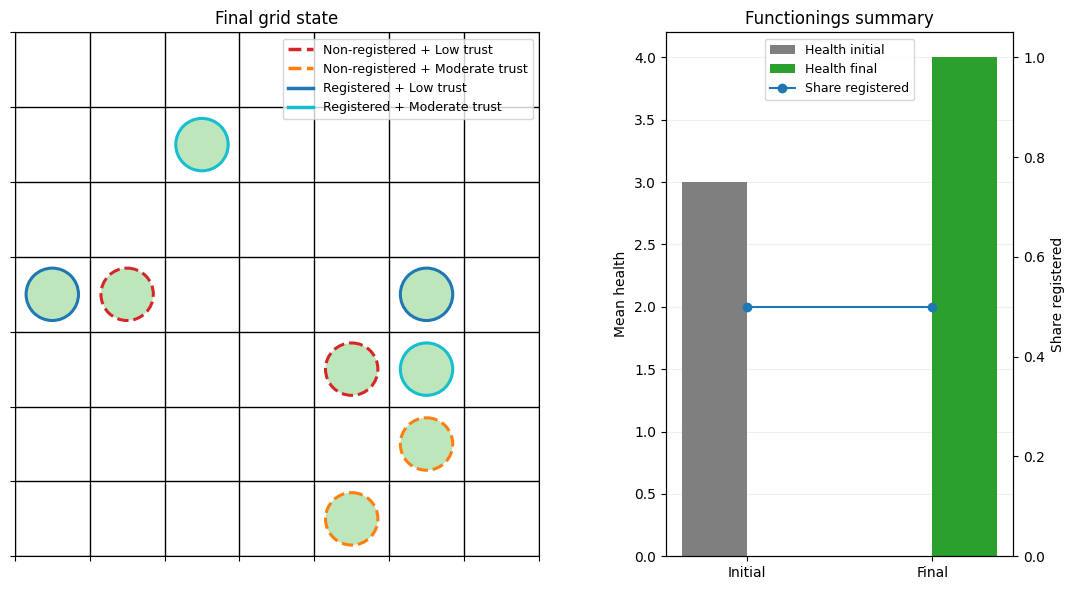

In [56]:
from types import SimpleNamespace

import json
from types import SimpleNamespace

def load_meta_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_locations(meta_dict):
    # depèn de com ho guardis: "context", "static_context", etc.
    ctx = meta_dict.get("context") or meta_dict.get("static_context") or {}
    return ctx.get("locations", {}) or meta_dict.get("locations", {})

def build_env_stub_from_agents_panel(df_agents, meta_dict=None, size=None):
    last_t = df_agents["t_global"].max()
    last = df_agents[df_agents["t_global"] == last_t].copy()

    agents = last["agent"].tolist()
    name_map = {ag:i for i,ag in enumerate(agents)}

    peh_agents = []
    for _, row in last.iterrows():
        peh_agents.append(SimpleNamespace(
            health_state=float(row["health"]),
            administrative_state=str(row["admin"]),
            location=(int(row["x"]), int(row["y"]))
        ))

    if size is None:
        # prova a deduir de meta
        size = None
        if meta_dict:
            size = meta_dict.get("grid_size") or meta_dict.get("size")
        size = int(size) if size is not None else 7  # fallback

    locations = extract_locations(meta_dict) if meta_dict else {}

    env_stub = SimpleNamespace(
        size=size,
        context=SimpleNamespace(locations=locations),
        possible_agents=agents,
        agent_name_mapping=name_map,
        peh_agents=peh_agents,
        socserv_agents=[],
    )
    return env_stub

def build_traces_from_agents_panel(df_agents):
    # traces per agent a partir del panel
    df = df_agents.sort_values(["t_global"])
    health_trace = {ag: g["health"].astype(float).tolist() for ag,g in df.groupby("agent")}
    admin_trace  = {ag: (g["admin"].astype(str) == "registered").astype(int).tolist() for ag,g in df.groupby("agent")}
    return health_trace, admin_trace

health_trace_on, admin_trace_on = build_traces_from_agents_panel(df_agents_on)
health_trace_off, admin_trace_off = build_traces_from_agents_panel(df_agents_off)
meta_on  = load_meta_json(r"out_datasets/run_001_ON_meta.json")
meta_off = load_meta_json(r"out_datasets/run_001_OFF_meta.json")
env_on  = build_env_stub_from_agents_panel(df_agents_on)
env_off = build_env_stub_from_agents_panel(df_agents_off)

initial_admin_on  = df_agents_on.set_index("agent")["admin"].to_dict()   # o init_admin si la tens
initial_trust_on  = df_agents_on.set_index("agent")["trust"].to_dict()   # o init_trust

initial_admin_off  = df_agents_off.set_index("agent")["admin"].to_dict()   # o init_admin si la tens
initial_trust_off  = df_agents_off.set_index("agent")["trust"].to_dict()   # o init_trust

utils.final_state_summary_figure(env_on,  health_trace_on,  admin_trace_on,  initial_admin_on, initial_trust_on)
utils.final_state_summary_figure(env_off, health_trace_off, admin_trace_off, initial_admin_off, initial_trust_off)